# Variables

In [112]:
function_number = 1 # Even, Triangular, Gaussian, Epanechnikov, Variance
bandwith = 100
resolution = 10
interval = ceil(bandwith/resolution)

# Instalar dependencias

In [113]:
!pip install pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [114]:
import pandas as pd
import pyproj
from math import sqrt, ceil, floor, e as euler, pi
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

# Df

In [115]:
url = 'https://foscalinternacional.com/datasets/eventos_dengue_2020.csv'
df = pd.read_csv(url)

In [116]:
df = df.drop('ID', axis=1)

In [117]:
def set_datetime(column):
  df[column] = pd.to_datetime(df[column], format='%d/%m/%Y')

In [118]:
columns = ['fec_not', 'fecha_contagio', 'inicio_sintomas', 'fecha_nacimiento']

In [119]:
for column in columns:
  set_datetime(column)

# Pyproj

In [120]:
P = pyproj.Proj(proj='utm', zone=18, elips='WGS84', preserve_units=True)

In [121]:
df['x'], df['y'] = P(df['longitud'], df['latitud'])

# Añadir distancia de la alcaldía

In [122]:
x_alcaldia, y_alcaldia = P(-73.086038, 7.062898)

In [123]:
df['distancia'] = None

In [124]:
for i in range(df.shape[0]):
  df.loc[i, 'distancia'] = sqrt(((df['x'][i] - x_alcaldia)**2) + ((df['y'][i] - y_alcaldia)**2))

# Correlacion

In [125]:
df2 = df
df2 = df2.select_dtypes(exclude=['object', 'datetime64'])
df2 = df2.drop(['año', 'cod_pais_o', 'condicion_final', 'fecha_defuncion', 'certif_defuncion'], axis=1)

In [126]:
'''
colormap = plt.cm.viridis
plt.figure(figsize=(24,24))
plt.title('Pearson Correlation', y=1.05, size=15)
sb.heatmap(df2.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
'''

"\ncolormap = plt.cm.viridis\nplt.figure(figsize=(24,24))\nplt.title('Pearson Correlation', y=1.05, size=15)\nsb.heatmap(df2.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)\n"

# Mapa de calor


In [127]:
bandwith = 100
resolution = 10
interval = ceil(bandwith/resolution)

min_x = min(df['x']) - bandwith
max_x = max(df['x']) + bandwith
min_y = min(df['y']) - bandwith
max_y = max(df['y']) + bandwith

len_x = ceil((max_x - min_x) / resolution)
len_y = ceil((max_y - min_y) / resolution)

matrix = [[0 for x in range(len_x)] for y in range(len_y)]

In [128]:
for i in range(df.shape[0]):
  pos_x = floor((df.loc[i, 'x'] - min_x) / resolution)
  pos_y = floor((df.loc[i, 'y'] - min_y) / resolution)
  matrix[pos_y][pos_x] += 1

In [129]:
'''
fig = plt.figure(figsize=(50, 40))

ax = fig.add_subplot(111)
ax.set_title('Mapa de calor')
plt.imshow(matrix)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()
'''

"\nfig = plt.figure(figsize=(50, 40))\n\nax = fig.add_subplot(111)\nax.set_title('Mapa de calor')\nplt.imshow(matrix)\nax.set_aspect('equal')\n\ncax = fig.add_axes([0.12, 0.1, 0.78, 0.8])\ncax.get_xaxis().set_visible(False)\ncax.get_yaxis().set_visible(False)\ncax.patch.set_alpha(0)\ncax.set_frame_on(False)\nplt.colorbar(orientation='vertical')\nplt.show()\n"

# Poner la densidad sin función de agrupación


## Metodo 1

In [130]:
'''
matrix_acc = [[0 for x in range(len_x)] for y in range(len_y)]
for i in range(len(matrix)):
  for j in range(len(matrix[i])):
    i_lower = i-interval if i >= interval else 0
    i_upper = i+interval if i <= len(matrix)-interval else len(matrix)
    j_lower = j-interval if j >= interval else 0
    j_upper = j+interval if j <= len(matrix[i])-interval else len(matrix[i])
    for k in range(i_lower, i_upper):
      for l in range(j_lower, j_upper):
        distance = sqrt(((i-k)**2) + ((j-l)**2)) * resolution
        if distance <= bandwith:
          matrix_acc[i][j] += matrix[k][l]
'''

'\nmatrix_acc = [[0 for x in range(len_x)] for y in range(len_y)]\nfor i in range(len(matrix)):\n  for j in range(len(matrix[i])):\n    i_lower = i-interval if i >= interval else 0\n    i_upper = i+interval if i <= len(matrix)-interval else len(matrix)\n    j_lower = j-interval if j >= interval else 0\n    j_upper = j+interval if j <= len(matrix[i])-interval else len(matrix[i])\n    for k in range(i_lower, i_upper):\n      for l in range(j_lower, j_upper):\n        distance = sqrt(((i-k)**2) + ((j-l)**2)) * resolution\n        if distance <= bandwith:\n          matrix_acc[i][j] += matrix[k][l]\n'

## Metodo 2

In [131]:
matrix_acc = [[0 for x in range(len_x)] for y in range(len_y)]
for i in range(len(matrix)):
  for j in range(len(matrix[i])):
    if matrix[i][j] != 0:
      i_lower = i-interval if i >= interval else 0
      i_upper = i+interval if i <= len(matrix)-interval else len(matrix)
      j_lower = j-interval if j >= interval else 0
      j_upper = j+interval if j <= len(matrix[i])-interval else len(matrix[i])
      for k in range(floor(i_lower), ceil(i_upper)):
        for l in range(floor(j_lower), ceil(j_upper)):
          distance = sqrt(((i-k)**2) + ((j-l)**2)) * resolution
          if distance <= bandwith:
            matrix_acc[k][l] += matrix[i][j]

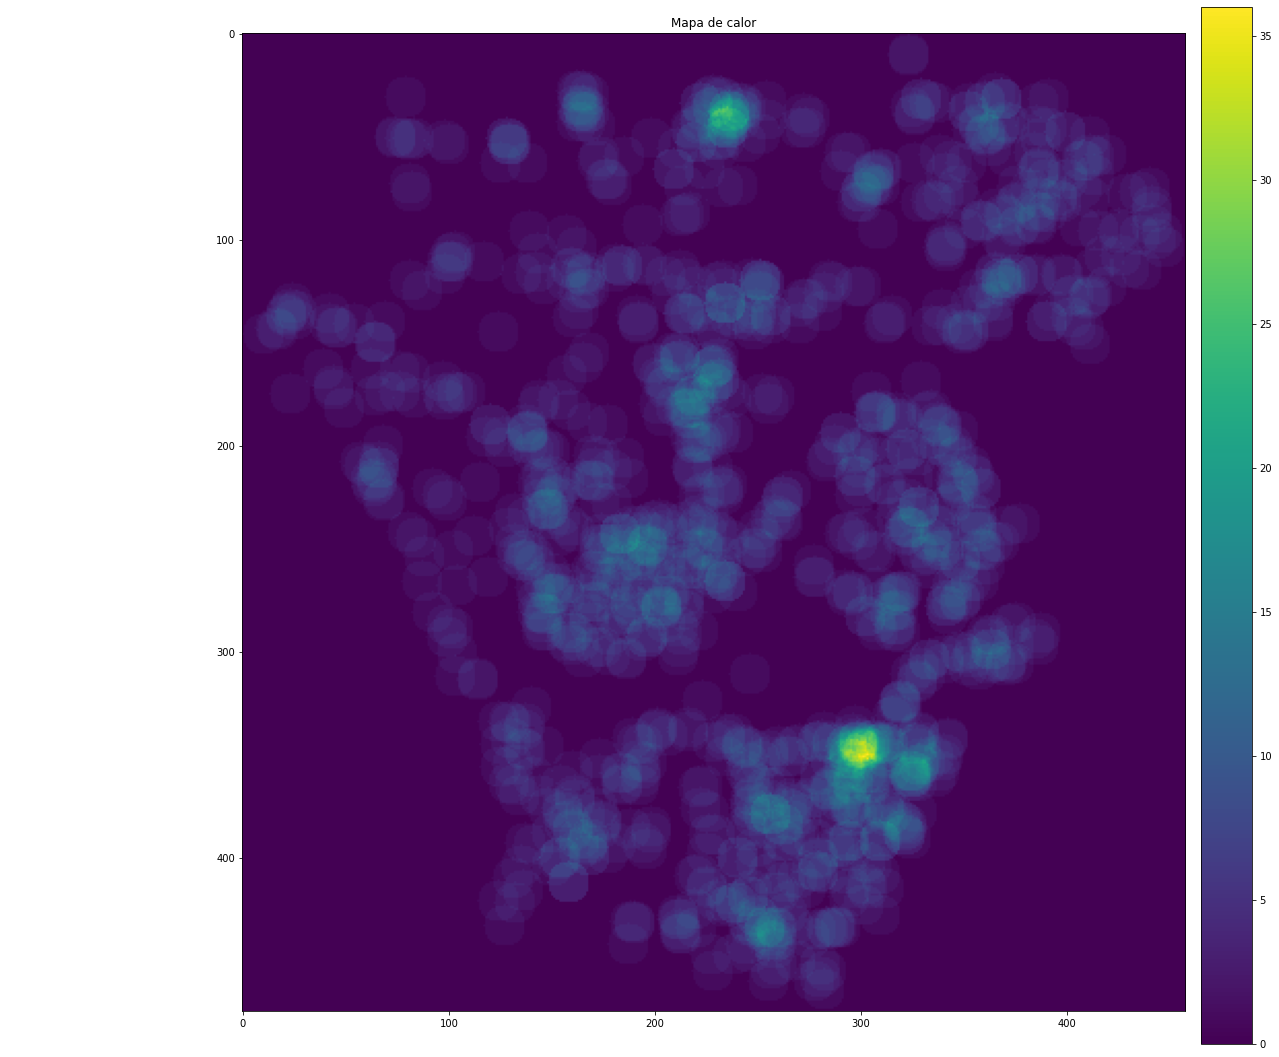

In [132]:
fig = plt.figure(figsize=(25, 18))

ax = fig.add_subplot(111)
ax.set_title('Mapa de calor')
plt.imshow(matrix_acc)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical', pad=0.2)
plt.show()

# Poner densidad con función de agrupación


## Función de agrupación

In [133]:
class DensityFunction():
  def __init__(self, x, bandwith):
    self.x = x
    self.bandwith = bandwith
  
  def calculate_function(self, n: int):
    if n == 1:
      return self._even()
    elif n == 2:
      return self._triangular()
    elif n == 3:
      return self._gaussian()
    elif n == 4:
      return self._epanechnikov()
    elif n == 5:
      return self._variance()

  def _get_x(self):
    return abs(self.x/self.bandwith)

  def _even(self):
    y = 0.5
    return y
  
  def _triangular(self):
    y = 1 - abs(self._get_x())
    return y

  def _gaussian(self):
    y = (euler**-((self._get_x()/2)**2))/sqrt(2*pi)
    return y

  def _epanechnikov(self):
    y = (3/4)*(1-(self._get_x()**2))
    return y

  def _variance(self):
    y = (3/8)*(3-(5*(self._get_x())**2))
    return y


In [134]:
matrix_acc = [[0 for x in range(len_x)] for y in range(len_y)]
for i in range(len(matrix)):
  for j in range(len(matrix[i])):
    if matrix[i][j] != 0:
      i_lower = i-interval if i >= interval else 0
      i_upper = i+interval if i <= len(matrix)-interval else len(matrix)
      j_lower = j-interval if j >= interval else 0
      j_upper = j+interval if j <= len(matrix[i])-interval else len(matrix[i])
      for k in range(floor(i_lower), ceil(i_upper)):
        for l in range(floor(j_lower), ceil(j_upper)):
          distance = sqrt(((i-k)**2) + ((j-l)**2)) * resolution
          if distance <= bandwith:
            density_group = DensityFunction(distance, bandwith)
            for m in range(matrix[i][j]):
              matrix_acc[k][l] += density_group.calculate_function(function_number)

var = pi * bandwith**2
for i in range(len(matrix_acc)):
  for j in range(len(matrix_acc[i])):
    matrix_acc[i][j] = matrix_acc[i][j]/var


# Visualizar

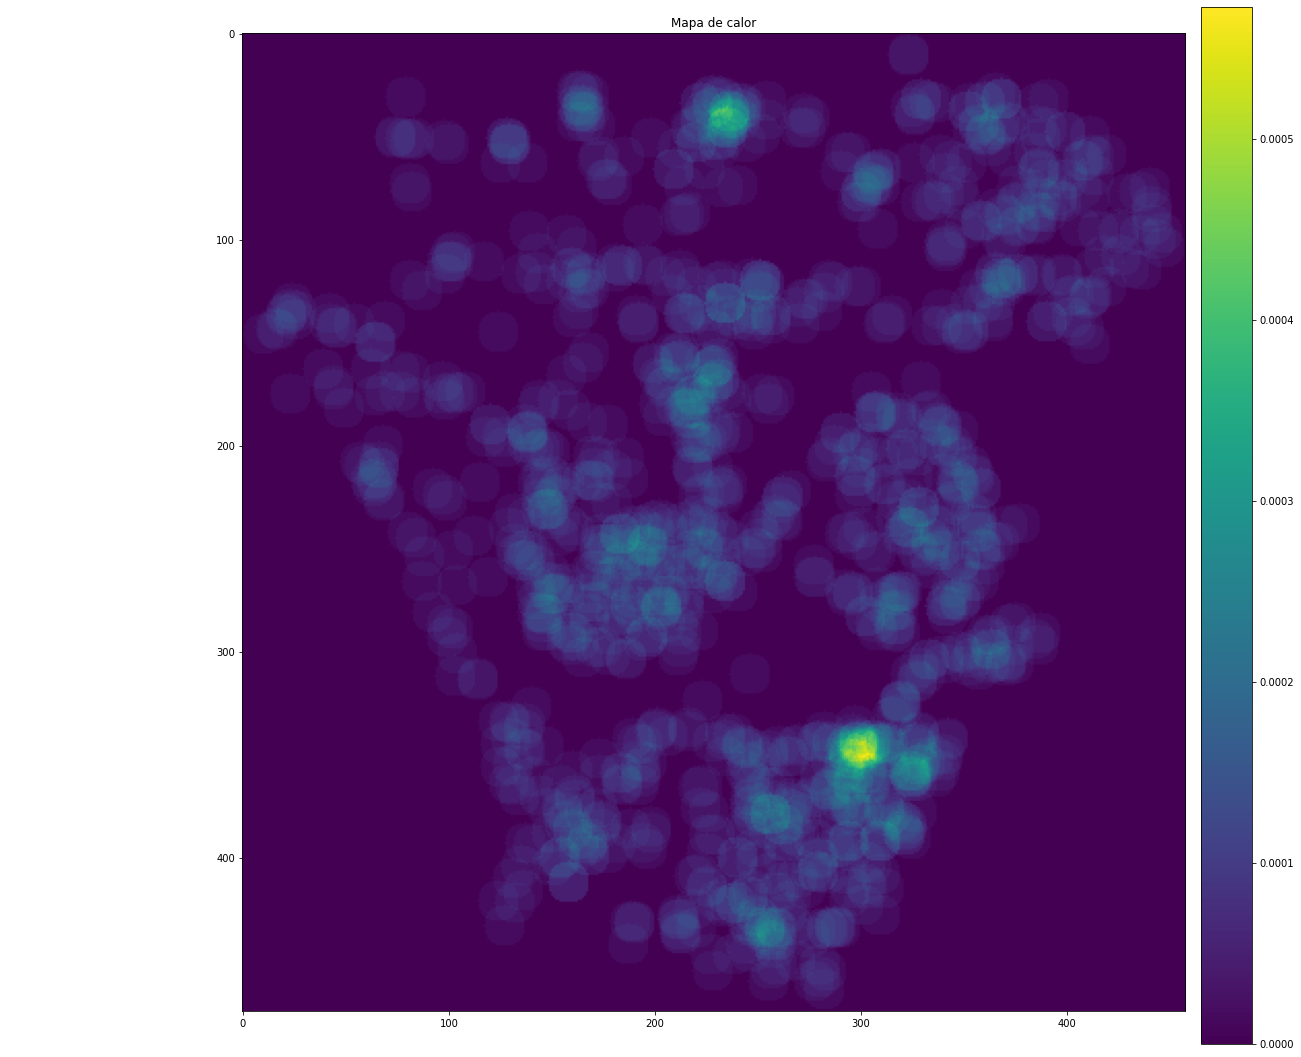

In [135]:
fig = plt.figure(figsize=(25, 18))

ax = fig.add_subplot(111)
ax.set_title('Mapa de calor')
plt.imshow(matrix_acc)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical', pad=0.2)
plt.show()